## Fetch Data Analyst Take Home
Three unstructured CSV files are provided along with the take home instructions. They contain data on users, transactions, and products. 
I will be using Python in this jupyter notebook for the exercises. Utilizing pandas/sqlite3 to load/transform the data and matplotlib/seaborn to visualize it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime

# set seaborn style
sns.set_theme()

In [2]:
# Read CSV files
users = pd.read_csv("users.csv")
transactions = pd.read_csv("transactions.csv")
products = pd.read_csv("products.csv")

# Print dataframe shapes
print("Users shape:", users.shape)
print("Transactions shape:", transactions.shape)
print("Products shape:", products.shape)

Users shape: (100000, 6)
Transactions shape: (50000, 8)
Products shape: (845552, 7)


## Exercise 1: Explore the Data
Are there any data quality issues present?
Are there any fields that are challenging to understand?

In [3]:
# Lets print the column names
print(f"Users columns: {users.columns.values}")
print(f"Transactions columns: {transactions.columns.values}")
print(f"Products columns: {products.columns.values}")

Users columns: ['ID' 'CREATED_DATE' 'BIRTH_DATE' 'STATE' 'LANGUAGE' 'GENDER']
Transactions columns: ['RECEIPT_ID' 'PURCHASE_DATE' 'SCAN_DATE' 'STORE_NAME' 'USER_ID' 'BARCODE'
 'FINAL_QUANTITY' 'FINAL_SALE']
Products columns: ['CATEGORY_1' 'CATEGORY_2' 'CATEGORY_3' 'CATEGORY_4' 'MANUFACTURER'
 'BRAND' 'BARCODE']


In [4]:
# Check for duplicate rows in user data
user_duplicate_rows = users.duplicated().sum()
print(f"Number of duplicate rows: {user_duplicate_rows}")

# Check for duplicate ID in user data
user_duplicate_ids = users.duplicated(subset=["ID"]).sum()
print(f"Number of duplicate IDs: {user_duplicate_ids}")

Number of duplicate rows: 0
Number of duplicate IDs: 0


There are no duplicate rows or duplicate IDs in the users dataset.

In [5]:
# Check unique state values
print("Unique states:", users["STATE"].unique())

# Check unique language values
print("Unique languages:", users["LANGUAGE"].unique())

# Check unique gender values
print("Unique genders:", users["GENDER"].unique())

Unique states: ['CA' 'PA' 'FL' 'NC' 'NY' 'IN' nan 'OH' 'TX' 'NM' 'PR' 'CO' 'AZ' 'RI' 'MO'
 'NJ' 'MA' 'TN' 'LA' 'NH' 'WI' 'IA' 'GA' 'VA' 'DC' 'KY' 'SC' 'MN' 'WV'
 'DE' 'MI' 'IL' 'MS' 'WA' 'KS' 'CT' 'OR' 'UT' 'MD' 'OK' 'NE' 'NV' 'AL'
 'AK' 'AR' 'HI' 'ME' 'ND' 'ID' 'WY' 'MT' 'SD' 'VT']
Unique languages: ['es-419' 'en' nan]
Unique genders: ['female' nan 'male' 'non_binary' 'transgender' 'prefer_not_to_say'
 'not_listed' 'Non-Binary' 'unknown' 'not_specified'
 "My gender isn't listed" 'Prefer not to say']


By checking the unique values of the state, language, and gender columns, we can check the quality of the values present. The state and language values are easy to understand with both containing 'nan' for missing data. We can see that state values includes DC (Washington DC) and PR (Puerto Rico) as well. 

The gender values are of poor quality. We have multiple values for "non-binary", "not listed", and "prefer not to say" responses. Also, it's challenging to understand whether "unknown" and "not specified" are the same response. 

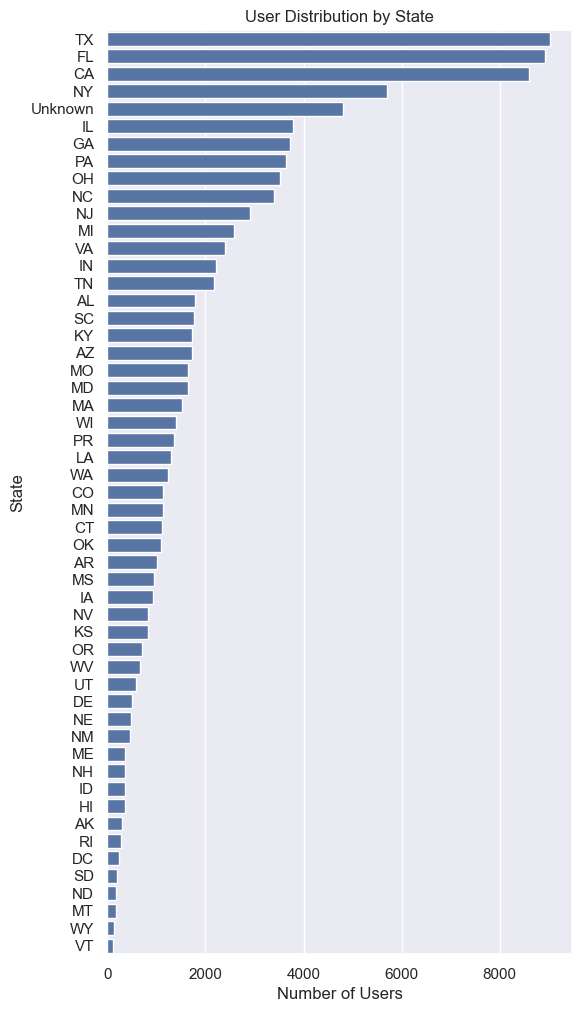

In [6]:
# Make copy of users for plots
plot_users = users.copy()

# Replace NaN values in "STATE" and with a placeholder
plot_users["STATE"] = plot_users["STATE"].fillna("Unknown")

# Create the barplot
plt.figure(figsize=(6, 12))
sns.countplot(data=plot_users, y="STATE", order=plot_users["STATE"].value_counts().index, color="#4c72b0")

# Labels and title
plt.xlabel("Number of Users")
plt.ylabel("State")
plt.title("User Distribution by State")
plt.show()

The plot above shows the distribution of total users for each state, ordered by the number of users. We can see a large number of users from populous states like Texas, Florida, California, and New York. There is also a large number of users with no state information under "Unknown".

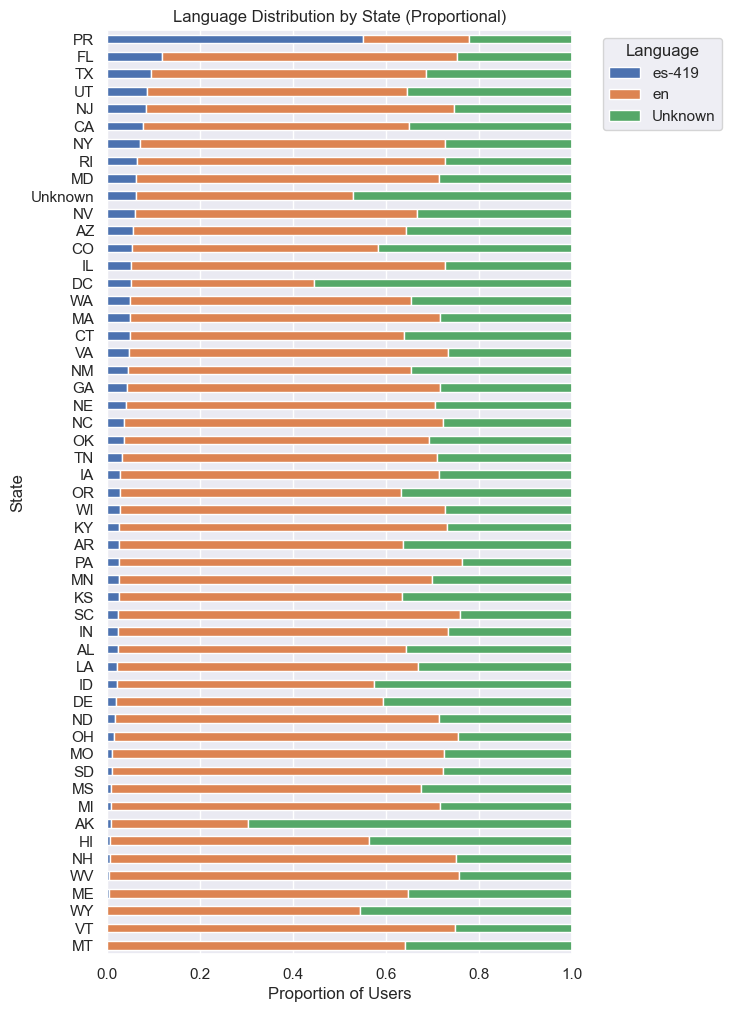

In [7]:
# Replace NaN values in "LANGUAGE" and with a placeholder
plot_users["LANGUAGE"] = plot_users["LANGUAGE"].fillna("Unknown")

# Count occurrences of each language per state
lang_dist = plot_users.groupby(["STATE", "LANGUAGE"]).size().unstack(fill_value=0)

# Calculate the proportion of spanish-speaking users in each state
lang_dist["ES_proportion"] = lang_dist.get("es-419", 0) / lang_dist.sum(axis=1)

# Sort states by the proportion of spanish-speakers in descending order
lang_dist = lang_dist.sort_values(by="ES_proportion", ascending=True)

# Normalize each state's language counts (percentage-based)
lang_dist = lang_dist.div(lang_dist.sum(axis=1), axis=0)

# Specify the desired order for the languages in the plot
language_order = ["es-419", "en", "Unknown"] 

# Reorder the columns of lang_dist based on language_order
lang_dist = lang_dist[language_order]

# Plot as a 100% stacked bar chart
ax = lang_dist.plot(
    kind="barh", 
    stacked=True, 
    figsize=(6, 12), 
    title="Language Distribution by State (Proportional)"
)

# Labels & Limits
plt.xlabel("Proportion of Users")
plt.ylabel("State")
plt.xlim(0, 1)

# Show legend outside
plt.legend(title="Language", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()


The above plot shows the proportion of user's languages per state. I thought it would be interesting to sort by the states/regions with the highest proportion of spanish speakers. Not surprisingly we have Puerto Rico (>50%) at the top with Florida and Texas following up around 10%. 

ID               0.000
CREATED_DATE     0.000
BIRTH_DATE       3.675
STATE            4.812
GENDER           5.892
LANGUAGE        30.508
dtype: float64


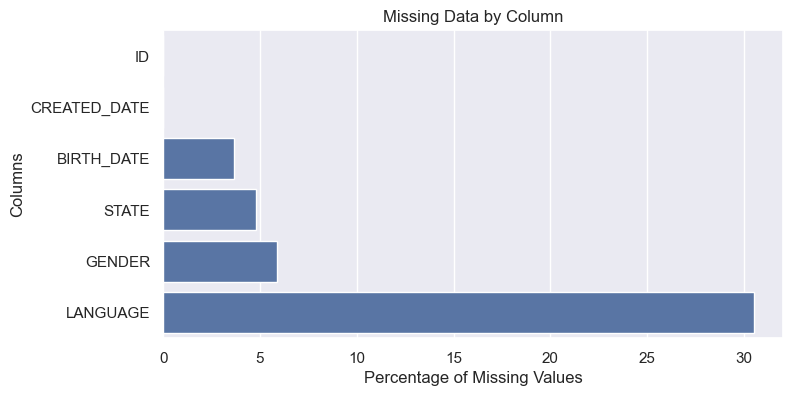

In [8]:
# Calculate the percentage of missing values for each column
missing_values = (users.isnull().sum() / len(users)) * 100

# Sort values for better visualization
missing_values = missing_values.sort_values()
print(missing_values)

# Plot using Seaborn
plt.figure(figsize=(8, 4))
sns.barplot(y=missing_values.index, x=missing_values.values, color="#4c72b0")

# Formatting
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Data by Column")

plt.show()

The plot above shows the percentage of missing row values per column for the users dataset. No values are missing from ID and CREATED_DATE. BIRTH_DATE, STATE, and GENDER have under 10% of their values missing while LANGUAGE has over 30% of values missing. This poor data quality, especially with so much missing data in the LANGUAGE column, will make answering user questions filtered by language difficult.

In [9]:
# Check for duplicate rows in transaction data
transaction_duplicate_rows = transactions.duplicated().sum()
print(f"Number of duplicate rows: {transaction_duplicate_rows}")

# Check for duplicate (RECEIPT_ID, USER_ID, BARCODE) in transaction data
transaction_duplicate_ids = transactions.duplicated(subset=["RECEIPT_ID", "USER_ID", "BARCODE"]).sum()
print(f"Number of duplicate (RECEIPT_ID, USER_ID, BARCODE): {transaction_duplicate_ids}")

Number of duplicate rows: 171
Number of duplicate (RECEIPT_ID, USER_ID, BARCODE): 25205


There are a handful of complete duplicate rows and a significant amount of rows with duplicate (RECEIPT_ID, USER_ID, BARCODE). I'm assuming (RECEIPT_ID, USER_ID, BARCODE) creates a unique transaction.

In [10]:
transactions.sort_values(by=["RECEIPT_ID", "USER_ID", "BARCODE"]).head(10)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
41567,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,1.54
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
39291,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,1.00,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
25928,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,2.54
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
41475,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,1.00,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,
43233,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,5.29


By looking at the head of this dataset, sorted by (RECEIPT_ID, USER_ID, BARCODE), we can see duplicates in which one duplicate row either has missing data in FINAL_SALE or has a non-numerical value of "zero" in FINAL_QUANTITY.

In [11]:
# Check unique store name values
print("Unique store names:", transactions["STORE_NAME"].unique().shape[0])

# Check unique quantity values
print("Unique quantities:", transactions["FINAL_QUANTITY"].unique())

Unique store names: 954
Unique quantities: ['1.00' 'zero' '2.00' '3.00' '4.00' '4.55' '2.83' '2.34' '0.46' '7.00'
 '18.00' '12.00' '5.00' '2.17' '0.23' '8.00' '1.35' '0.09' '2.58' '1.47'
 '16.00' '0.62' '1.24' '1.40' '0.51' '0.53' '1.69' '6.00' '2.39' '2.60'
 '10.00' '0.86' '1.54' '1.88' '2.93' '1.28' '0.65' '2.89' '1.44' '2.75'
 '1.81' '276.00' '0.87' '2.10' '3.33' '2.54' '2.20' '1.93' '1.34' '1.13'
 '2.19' '0.83' '2.61' '0.28' '1.50' '0.97' '0.24' '1.18' '6.22' '1.22'
 '1.23' '2.57' '1.07' '2.11' '0.48' '9.00' '3.11' '1.08' '5.53' '1.89'
 '0.01' '2.18' '1.99' '0.04' '2.25' '1.37' '3.02' '0.35' '0.99' '1.80'
 '3.24' '0.94' '2.04' '3.69' '0.70' '2.52' '2.27']


Originally I assumed the FINAL_QUANITY was going to be an integer (ex: two apples, three tooth brushes, etc.) but it looks like it very well may also be a weight (ex: pounds of apples). This could cause confusion in the future, especially since the units could change depending on the value.

RECEIPT_ID        0.000
PURCHASE_DATE     0.000
SCAN_DATE         0.000
STORE_NAME        0.000
USER_ID           0.000
FINAL_QUANTITY    0.000
FINAL_SALE        0.000
BARCODE           5.762
dtype: float64


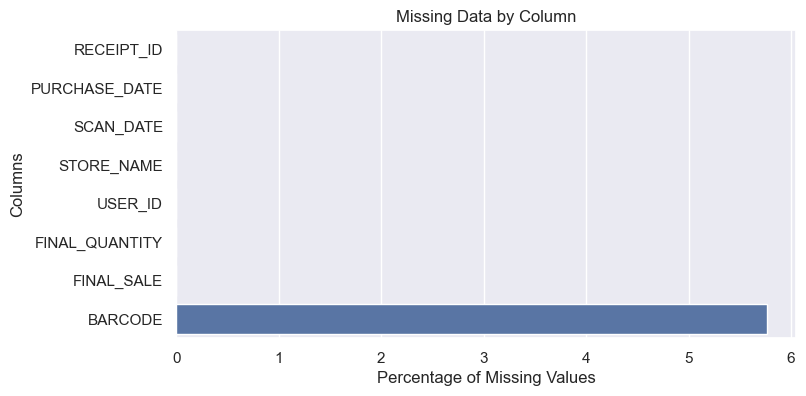

In [12]:
# Calculate the percentage of missing values for each column
missing_values = (transactions.isnull().sum() / len(users)) * 100

# Sort values for better visualization
missing_values = missing_values.sort_values()
print(missing_values)

# Plot using Seaborn
plt.figure(figsize=(8, 4))
sns.barplot(y=missing_values.index, x=missing_values.values, color="#4c72b0")

# Formatting
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Data by Column")

plt.show()

For most of the columns in the transactions dataset, no values are missing. But BARCODE does have about 5.7% of its values missing, meaning if we merged with the products dataset we would not be able to get the associated product info.

In [13]:
# Check for duplicate rows in product data
product_duplicate_rows = products.duplicated().sum()
print(f"Number of duplicate rows: {product_duplicate_rows}")

# Check for duplicate BARCODE in product data
product_duplicate_bars = products.duplicated(subset=["BARCODE"]).sum()
print(f"Number of duplicate BARCODEs: {product_duplicate_bars}")

Number of duplicate rows: 215
Number of duplicate BARCODEs: 4209


The products dataset has some duplicate rows and a handful of duplicate barcodes. I'm assuming there are multiple rows with the same barcode because the same barcode (product) may have been appended again with new information. 

In [14]:
# Check unique category 1 values
print("Unique Category 1:", products["CATEGORY_1"].unique())

# Check number of unique values
print("Number of Unique Category 2:", products["CATEGORY_2"].unique().shape[0])
print("Number of Unique Category 3:", products["CATEGORY_3"].unique().shape[0])
print("Number of Unique Category 4:", products["CATEGORY_4"].unique().shape[0])
print("Number of Unique Manufacturers:", products["MANUFACTURER"].unique().shape[0])
print("Number of Unique Brands:", products["BRAND"].unique().shape[0])

Unique Category 1: ['Health & Wellness' 'Snacks' 'Beverages' 'Pantry' 'Alcohol'
 'Apparel & Accessories' 'Restaurant' 'Needs Review' 'Dairy'
 'Home & Garden' nan 'Household Supplies' 'Meat & Seafood' 'Deli & Bakery'
 'Sporting Goods' 'Produce' 'Office & School' 'Frozen'
 'Arts & Entertainment' 'Animals & Pet Supplies' 'Electronics' 'Beauty'
 'Toys & Games' 'Mature' 'Vehicles & Parts' 'Baby & Toddler'
 'Luggage & Bags' 'Media']
Number of Unique Category 2: 122
Number of Unique Category 3: 345
Number of Unique Category 4: 128
Number of Unique Manufacturers: 4355
Number of Unique Brands: 8123


I'm assuming category 1-4 are hierarchically structured where category 2 contains subcategories of category 1 and so on. We can check this.

In [15]:
category_2_counts = products.groupby("CATEGORY_1")["CATEGORY_2"].nunique().reset_index()
print("Number of Category 2 subcategories:", category_2_counts.CATEGORY_2.sum())

category_3_counts = products.groupby("CATEGORY_2")["CATEGORY_3"].nunique().reset_index()
print("Number of Category 3 subcategories:", category_3_counts.CATEGORY_3.sum())

category_4_counts = products.groupby("CATEGORY_3")["CATEGORY_4"].nunique().reset_index()
print("Number of Category 4 subcategories:", category_4_counts.CATEGORY_4.sum())

Number of Category 2 subcategories: 121
Number of Category 3 subcategories: 345
Number of Category 4 subcategories: 127


By grouping by the parent category and counting the unique subcategories, we can compare these counts to the number of unique counts from above. The counts are essentially the same. Missing values (NaN) are not counted which would account for the discrepancy of 1. Also, there is a chance a child category is shared by multiple parents. 

CATEGORY_1       0.013128
CATEGORY_2       0.168411
BARCODE          0.476020
CATEGORY_3       7.162895
BRAND           26.783923
MANUFACTURER    26.784160
CATEGORY_4      92.021898
dtype: float64


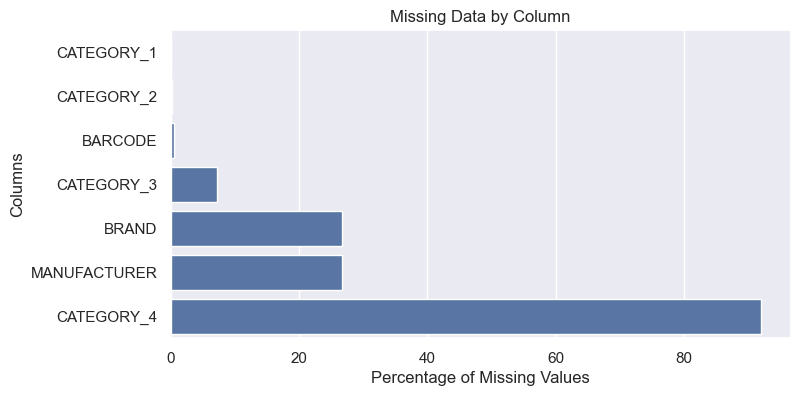

In [16]:
# Calculate the percentage of missing values for each column
missing_values = (products.isnull().sum() / len(products)) * 100

# Sort values for better visualization
missing_values = missing_values.sort_values()
print(missing_values)

# Plot using Seaborn
plt.figure(figsize=(8, 4))
sns.barplot(y=missing_values.index, x=missing_values.values, color="#4c72b0")

# Formatting
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Data by Column")

plt.show()

Category 3 and 4 data is missing which makes sense because not all products will have multiple nested subcategories. Category 4 has 92% missing. About 25% of the manufacturer/brand data is missing.

In [17]:
# Create new copy of transactions by filtering out "zero" in FINAL_QAUNTITY
new_transactions = transactions[transactions["FINAL_QUANTITY"] != "zero"].copy()

# Convert FINAL_QUANTITY and FINAL_SALE to nummeric columns
new_transactions.loc[:, "FINAL_QUANTITY"] = pd.to_numeric(new_transactions.loc[:, "FINAL_QUANTITY"], errors="coerce")
new_transactions.loc[:, "FINAL_SALE"] = pd.to_numeric(new_transactions.loc[:, "FINAL_SALE"], errors="coerce")

# Drop rows that have NaN in FINAL_QUANTITY and FINAL_SALE
new_transactions = new_transactions.dropna(subset=["FINAL_QUANTITY"])
new_transactions = new_transactions.dropna(subset=["FINAL_SALE"])

# Drop exact duplicate rows
new_transactions = new_transactions.drop_duplicates()

# Drop duplicates based on "RECEIPT_ID", "USER_ID", "BARCODE", keeping the first occurrence
new_transactions = new_transactions.drop_duplicates(subset=["RECEIPT_ID", "USER_ID", "BARCODE"], keep="first")

In [18]:
# Check for duplicate rows in new transaction data
new_transaction_duplicate_rows = new_transactions.duplicated().sum()
print(f"Number of duplicate rows: {new_transaction_duplicate_rows}")

# Check for duplicate (RECEIPT_ID, USER_ID, BARCODE) in new transaction data
new_transaction_duplicate_ids = new_transactions.duplicated(subset=["RECEIPT_ID", "USER_ID", "BARCODE"]).sum()
print(f"Number of duplicate IDs: {new_transaction_duplicate_ids}")

Number of duplicate rows: 0
Number of duplicate IDs: 0


By processing the transactions dataset, we can remove the duplicates as shown above.

In [19]:
new_transactions.sort_values(by=["RECEIPT_ID", "USER_ID", "BARCODE"]).head(10)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
41567,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.0,1.54
39291,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,1.0,1.49
25928,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.0,2.54
41475,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,1.0,3.49
43233,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.0,5.29
40388,0002d8cd-1701-4cdd-a524-b70402e2dbc0,2024-06-24,2024-06-24 19:44:54.247 Z,WALMART,5dcc6c510040a012b8e76924,6.811314e+11,1.0,1.46
47862,000550b2-1480-4c07-950f-ff601f242152,2024-07-06,2024-07-06 19:27:48.586 Z,WALMART,5f850bc9cf9431165f3ac175,4.920091e+10,1.0,3.12
36036,00096c49-8b04-42f9-88ce-941c5e06c4a7,2024-08-19,2024-08-21 17:35:21.902 Z,TARGET,6144f4f1f3ef696919f54b5c,7.830007e+10,1.0,3.59
41970,000e1d35-15e5-46c6-b6b3-33653ed3d27e,2024-08-13,2024-08-13 18:21:07.931 Z,WALMART,61a6d926f998e47aad33db66,5.200001e+10,1.0,0.98
40976,0010d87d-1ad2-4e5e-9a25-cec736919d15,2024-08-04,2024-08-04 18:01:47.787 Z,ALDI,66686fc2e04f743a096ea808,NaN,1.0,2.29


The transactions dataset looks much better than before!

In [20]:
# Create new copy of products where exact duplicate rows are dropped
new_products = products.copy().drop_duplicates()

# Drop rows that have NaN in BARCODE
new_products = new_products.dropna(subset=["BARCODE"])

# Drop duplicates based on "BARCODE", keeping the last occurrence
new_products = new_products.drop_duplicates(subset=["BARCODE"], keep="last")

For rows with a duplicate BARCODE, I keep the last occurence. I'm assuming the same BARCODE at a later index was added to update it's information.

In [21]:
# Check for duplicate rows in new product data
new_product_duplicate_rows = new_products.duplicated().sum()
print(f"Number of duplicate rows: {new_product_duplicate_rows}")

# Check for duplicate BARCODE in new product data
new_product_duplicate_bars = new_products.duplicated(subset=["BARCODE"]).sum()
print(f"Number of duplicate IDs: {new_product_duplicate_bars}")

Number of duplicate rows: 0
Number of duplicate IDs: 0


We do the same type of filtering/processing to the products dataset to remove duplicates.

In [22]:
# Total number of rows in new_transactions
print(f"Number of Transactions: {len(new_transactions)}")

# Calculate the number of user ids that are in new_transactions but not in users
missing_users = new_transactions[~new_transactions["USER_ID"].isin(users["ID"])]
print(f"Transactions with missing users: {len(missing_users)}")

# Calculate the number of product barcodes that are in new_transactions but not in new_products
missing_products = new_transactions[~new_transactions["BARCODE"].isin(new_products["BARCODE"])]
print(f"Transactions with missing products: {len(missing_products)}")

Number of Transactions: 24795
Transactions with missing users: 24665
Transactions with missing products: 12440


Just as a check, we can look at the number of rows in transactions that have USER_IDs that don't exist in the users dataset. It is unfortunately quite high (99%) which means if we merge in the user attributes (state, language, gender, etc.) we won't have any user information for those transactions. 

We can also look at the number of rows in transactions that have BARCODEs that don't exist in the products dataset. About 50% of the rows in transactions are affected. 

In [23]:
# Merge new_transactions with users on user_id
transactions_users = new_transactions.merge(users, left_on="USER_ID", right_on="ID", how="left")

# Merge transactions_users with new_products on barcode
full_data = transactions_users.merge(new_products, on="BARCODE", how="left")

print(f"Number of Rows: {len(full_data)}")

Number of Rows: 24795


We merge the three datasets together using USER_ID/ID and BARCODE. 

BARCODE         11.357128
CATEGORY_1      51.599113
CATEGORY_2      51.647510
BRAND           51.647510
MANUFACTURER    51.647510
CATEGORY_3      55.486993
CATEGORY_4      93.942327
STATE           99.475701
LANGUAGE        99.475701
ID              99.475701
CREATED_DATE    99.475701
GENDER          99.479734
BIRTH_DATE      99.479734
dtype: float64


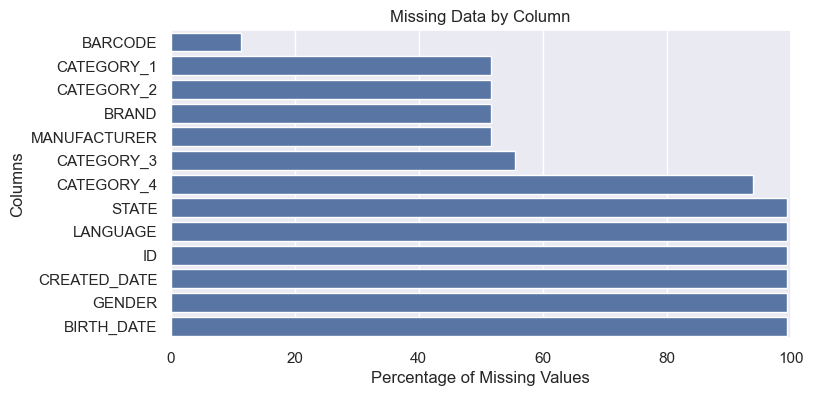

In [24]:
# Calculate the percentage of missing values for each column
missing_values = (full_data.isnull().sum() / len(full_data)) * 100

# Sort values for better visualization
missing_values = missing_values.sort_values()
missing_values = missing_values[missing_values > 0]
print(missing_values)

# Plot using Seaborn
plt.figure(figsize=(8, 4))
sns.barplot(y=missing_values.index, x=missing_values.values, color="#4c72b0")

# Formatting
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Data by Column")
plt.xlim(0, 100)

plt.show()

The plot shows the percentage of missing values for columns in the fully merged dataset. As we calculated earlier, about 99% of the user columns are missing since the USER_IDs don't exist in the users dataset. Also, the columns from products are missing since 50% of the BARCODEs found in the transaction rows don't exist in the products dataset. This is very unfortunate, especially if we want to answer questions regarding trends based on the user/product attributes.

## Exercise 2: Provide SQL Queries
Each question will be answered using one query.

In [25]:
full_data.sort_values(by=["BIRTH_DATE"]).head(10)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND
7308,be5a3916-5dee-45dc-b488-843a1245cfc9,2024-08-17,2024-08-17 16:02:06.547 Z,WALMART,5c6c2998b06c0045a4fddc74,7.874213e+10,1.0,2.78,5c6c2998b06c0045a4fddc74,2019-02-19 16:06:48.000 Z,1943-09-03 05:00:00.000 Z,OK,en,female,Snacks,Cookies,NaN,NaN,WALMART INC.,GREAT VALUE
17301,1545b6f9-813e-4c47-a673-fad21a219c00,2024-06-17,2024-06-17 22:07:41.785 Z,WALMART,5c6c2998b06c0045a4fddc74,2.430004e+10,1.0,2.68,5c6c2998b06c0045a4fddc74,2019-02-19 16:06:48.000 Z,1943-09-03 05:00:00.000 Z,OK,en,female,Snacks,Snack Cakes,Donut Snack Cakes,NaN,MCKEE FOODS,LITTLE DEBBIE
17125,6c757ce3-bcf4-47e2-9be9-295518246833,2024-07-11,2024-07-12 10:42:17.105 Z,DOLLAR TREE STORES INC,62c627d9b79924d29cc06f5a,9.990072e+10,1.0,1.25,62c627d9b79924d29cc06f5a,2022-07-07 00:24:57.000 Z,1944-07-20 05:00:00.000 Z,IN,en,female,Snacks,Candy,Chocolate Candy,NaN,FERRERO GROUP,BABY RUTH
22661,646ff0f9-2828-4483-ab38-fc952c3d4379,2024-08-14,2024-08-14 09:42:22.953 Z,WALMART,5f64fff6dc25c93de0383513,7.874213e+10,1.0,2.98,5f64fff6dc25c93de0383513,2020-09-18 18:44:07.000 Z,1948-09-02 04:00:00.000 Z,GA,en,male,NaN,NaN,NaN,NaN,NaN,NaN
14755,646ff0f9-2828-4483-ab38-fc952c3d4379,2024-08-14,2024-08-14 09:42:22.953 Z,WALMART,5f64fff6dc25c93de0383513,7.874201e+10,1.0,1.42,5f64fff6dc25c93de0383513,2020-09-18 18:44:07.000 Z,1948-09-02 04:00:00.000 Z,GA,en,male,NaN,NaN,NaN,NaN,NaN,NaN
1245,417a98f9-c71b-468c-b795-74c5576c0100,2024-08-14,2024-08-14 09:42:01.787 Z,WALMART,5f64fff6dc25c93de0383513,6.414405e+10,1.0,1.00,5f64fff6dc25c93de0383513,2020-09-18 18:44:07.000 Z,1948-09-02 04:00:00.000 Z,GA,en,male,NaN,NaN,NaN,NaN,NaN,NaN
489,9a6e4c08-b07b-4bad-ad44-330d2da1b67d,2024-06-17,2024-06-17 11:20:43.843 Z,WALMART,62815e99c907cf3f47d8ee35,8.100212e+11,1.0,1.97,62815e99c907cf3f47d8ee35,2022-05-15 20:12:09.000 Z,1948-10-26 05:00:00.000 Z,FL,en,female,Health & Wellness,Skin Care,Body Oil,NaN,PDC BRANDS,DR TEAL'S
10451,59df1c4c-ade1-4a77-97eb-e731bec19fed,2024-07-25,2024-07-26 19:50:38.133 Z,WALMART,664794617c0469953bf8932c,4.144900e+10,1.0,1.86,664794617c0469953bf8932c,2024-05-17 17:31:13.000 Z,1949-06-09 00:00:00.000 Z,OR,es-419,female,NaN,NaN,NaN,NaN,NaN,NaN
1161,59df1c4c-ade1-4a77-97eb-e731bec19fed,2024-07-25,2024-07-26 19:50:38.133 Z,WALMART,664794617c0469953bf8932c,3.338366e+10,1.0,1.22,664794617c0469953bf8932c,2024-05-17 17:31:13.000 Z,1949-06-09 00:00:00.000 Z,OR,es-419,female,NaN,NaN,NaN,NaN,NaN,NaN
12242,dd59569d-8e51-4f92-8b81-ed7fd0e1a411,2024-08-07,2024-08-07 17:02:08.904 Z,BJ'S WHOLESALE CLUB,62b67b8e37e6e08b0774f2c4,7.411795e+10,1.0,6.49,62b67b8e37e6e08b0774f2c4,2022-06-25 03:05:50.000 Z,1951-04-01 00:00:00.000 Z,NY,en,female,NaN,NaN,NaN,NaN,NaN,NaN


Above is a view of the merged dataset we will be working with. I will be rejoining/merging the datasets needed using SQL instead of using the already merged dataframe.

In [26]:
# Create an in-memory SQLite database
conn = sqlite3.connect(":memory:")

# Store DataFrames as SQL tables
new_transactions.to_sql("new_transactions", conn, index=False, if_exists="replace")
new_products.to_sql("new_products", conn, index=False, if_exists="replace")
users.to_sql("users", conn, index=False, if_exists="replace")

I will be using sqlite3 to create a in-memory SQLite database that I will query for each of the questions.

What are the top 5 brands by receipts scanned among users 21 and over?

In [27]:
# Run the SQL query
query = """
    SELECT p.brand, COUNT(DISTINCT t.receipt_id) AS receipt_count
    FROM new_transactions t
    LEFT JOIN new_products p ON t.barcode = p.barcode
    LEFT JOIN users u ON t.user_id = u.id
    WHERE (julianday("now") - julianday(u.birth_date)) >= (21 * 365) AND p.brand IS NOT NULL 
    GROUP BY p.brand
    ORDER BY receipt_count DESC
    LIMIT 5;
"""

# Execute the query and load results into a DataFrame
top_brands = pd.read_sql(query, conn)

# Display results
print(top_brands)

         BRAND  receipt_count
0         DOVE              3
1  NERDS CANDY              3
2    COCA-COLA              2
3  GREAT VALUE              2
4    HERSHEY'S              2


We can see that the receipt counts for the top 5 brands are quite low. This has to do with the fact that there is not much BIRTH_DATE data in our merged dataset as seen above in the missing data plot.

What are the top 5 brands by sales among users that have had their account for at least six months?

In [28]:
# Run the SQL query
query = """
      SELECT p.brand, SUM(t.final_sale) AS total_sales
      FROM new_transactions t
      LEFT JOIN new_products p ON t.barcode = p.barcode
      LEFT JOIN users u ON t.user_id = u.id
      WHERE (julianday("now") - julianday(u.created_date)) >= 182 AND p.brand IS NOT NULL 
      GROUP BY p.brand
      ORDER BY total_sales DESC
      LIMIT 5;
"""

# Execute the query and load results into a DataFrame
top_brands = pd.read_sql(query, conn)

# Display results
print(top_brands)

         BRAND  total_sales
0          CVS        72.00
1         DOVE        30.91
2      TRIDENT        23.36
3  COORS LIGHT        17.48
4     TRESEMMÉ        14.58


Again, total_sales for the top 5 brands is quite low because the majority of user data for CREATED_DATE is missing from the merged dataset.

Who are Fetch's power users? 

In [29]:
# Run the SQL query
query = """
    SELECT t.USER_ID, SUM(t.FINAL_SALE) AS total_sales
    FROM new_transactions t
    GROUP BY t.USER_ID
    ORDER BY total_sales DESC
    LIMIT 5;
"""

# Execute the query and load results into a DataFrame
top_users = pd.read_sql(query, conn)

# Display results
print(top_users)

                    USER_ID  total_sales
0  630789e1101ae272a4852287       462.82
1  650874eafe41d365c2ee11d2       267.29
2  63af23db9f3fc9c7546fdbec       238.17
3  645add3bffe0d7e043ef1b63       227.93
4  6535138fdda97e6b1342ea7f       146.65


Here I define a power user by how much they have spent (total_sales). Since this query only depends on data from the transactions dataset, it is not affected as much from missing data. 

Which is the leading brand in the Dips & Salsa category?

In [30]:
# Run the SQL query
query = """
    SELECT p.BRAND, SUM(t.FINAL_SALE) AS total_sales
    FROM new_transactions t
    LEFT JOIN new_products p ON t.BARCODE = p.BARCODE
    WHERE p.category_2 = "Dips & Salsa"
    GROUP BY p.BRAND
    ORDER BY total_sales DESC
    LIMIT 1;
"""

# Execute the query and load results into a DataFrame
top_brand = pd.read_sql(query, conn)

# Display results
print(top_brand)

      BRAND  total_sales
0  TOSTITOS        181.3


Here I define a leading brand by how much total sales they have. Since about half of the CATEGORY_2 data is missing from the joined/merged dataset, this result is affected heavily by the quality of the datasets.

In [31]:
# Close the connection
conn.close()

## Exercise 3: Communicate with Stakeholders

Subject: Quick Takeaways from Data Analysis

Hi [Stakeholder’s Name],

I wanted to share some key findings from my analysis of our user, transaction, and product data, along with a few questions that came up.

One major issue is data quality. Almost all transactions (99%) have user IDs that don’t match anything in our user dataset, and about half of the transactions reference barcodes that don’t exist in our product dataset. This makes it really difficult to analyze user behavior or product trends. There are also inconsistencies in some fields, like gender, where different variations of the same response appear. The quantity field is another example, where some values represent whole numbers while others seem to be weights, making it unclear how to interpret them. On top of that, we have a lot of missing data, especially for user attributes like birth date and language, which limits our ability to segment users in meaningful ways.

One thing that stood out is that our top power user has spent almost twice as much as the next highest spender. This raises some interesting questions. What’s driving this level of engagement? Is this a sign of a specific user segment we should be paying more attention to? Could it be an edge case or even an issue with the data?

To make better sense of all this, I could use some clarification on a few things. Are we working with incomplete extracts, or is there a reason so many user IDs and barcodes are missing? Should we be cleaning and standardizing fields like gender and quantity, and if so, is there an existing approach we should follow? Also, from a business perspective, how do we define a power user? Are there specific behaviors or thresholds we should be tracking beyond total spend?

Let me know your thoughts. Happy to jump on a call if it helps.

Best,

Alvaro